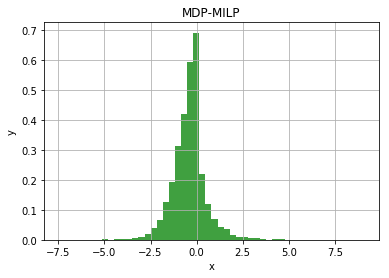

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# First plot an approximation of y vs. x to get a sense of what the distribution looks like
n = 10000
x = np.random.randn(n) # Recall: x ~ N(0, 1)
mu = list()
sigma = list()

for i in x: # Recall: y ~ N(min(x,0), max(x,0))
    mu.append(min(i,0))
    sigma.append(max(i,0))

y = mu + sigma*np.random.randn(n)
n, bins, patches = plt.hist(y, 50, density = 1, facecolor='g', alpha=0.75)

plt.xlabel('x')
plt.ylabel('y')
plt.title('MDP-MILP')
plt.grid(True)
plt.show() # It appears that ~0 is the value of x that maximizes y? idk :(

In [7]:
from gurobipy import *
import numpy as np

# Create model
model = Model("MDP-MILP")

# Create variables
x1 = model.addVar(lb = -1*GRB.INFINITY, ub=0.0, name = "x1") # Represents min(x, 0) -> x1 <= 0
x2 = model.addVar(lb=0.0, ub=GRB.INFINITY, name = "x2") # Represents max(x, 0) -> x2 >= 0
y = model.addVar(vtype=GRB.BINARY, name = "y") # Indicator variable for big M constraints

#Set coefficient e - objective function is a summation over n trials (accounts for stochasticity of e ~ N(0,1) I THINK?)
n = 10000 # Number of trials 
e = 0 # Coefficient for x2 -> e ~ N(0,1)
i = 0
while i < n:
    norm = np.random.normal(0.0, 1.0)
    e = e + norm
    i = i + 1
e = e/n

#Set objective 
model.setObjective(x1 + e*x2, GRB.MAXIMIZE)

#Set constraints - ensure that at least one of x1 or x2 is 0 (is this the right way to go about this?)
M = 10^6
model.addConstr(x2 <= M*(1-y)) # If y is 1, x2 must be 0 -> x2 <= 0 -> x2 = 0. Otherwise, no restriction on x2.
model.addConstr(x1 >= -1*M*y) # If y is 0, x1 must be 0 -> x1 >= 0 -> x1 = 0. Otherwise, no restriction on x1. 
model.update()

# Optimize model
model.optimize()

# Print Results 
for v in model.getVars():
    print('%s %g' % (v.varName, v.x))

print('Obj: %g' % model.objVal)
                   


Optimize a model with 2 rows, 3 columns and 4 nonzeros
Variable types: 2 continuous, 1 integer (1 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [8e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective -0

Explored 0 nodes (0 simplex iterations) in 0.02 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: -0 
Pool objective bound -0

Optimal solution found (tolerance 1.00e-04)
Best objective -0.000000000000e+00, best bound -0.000000000000e+00, gap 0.0000%
x1 0
x2 0
y 0
Obj: -0
